# Offline Controller

<img src="Pictures/offline_diagram.png" width="800">
<center>offline pipeline</center>

---
## Step 0: Import Modules
---

python default modules

In [1]:
# basic module
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from copy import deepcopy
from scipy.spatial.distance import euclidean
from scipy import stats
import torch
from dtw import *
from scipy.signal import savgol_filter

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



custom modules

In [2]:
# demonstration data handleing
sys.path.insert(0,'../dataHandling')
import data_utilities as du

# dynamic time warping
sys.path.insert(0,'../dynamic_time_warping')
import DTWz as dtwz

# parameter estimation
sys.path.insert(0,'../parameter_estimation')
import parameztimation as pez

---
## Step 0: Define Configuration Parameters
---

In [3]:
# data loading
filepath = '../../resources/training_data/task_up_combinedweight/' # path to the folder containing multiple .npy files
savepath = '../../resources/parameters/task_up_combinedweight/'
nmin = 400 # minimum demonstration length (0 means keep all)
dt = 0.01 # sampling time

# data preprocessing
length_equalize = True # equalize all length
desired_length = 100 # desired length
start_equalize = False # equalize all starting and ending points
amplitude_equalize = False # equalize signal amplitude (min/max)
filtergain = None # smoothen gain
force_deadband = -4.8 # if abs(force) < this value, force = 0
force_scaling = 0.1 # force scaling
perform_dtw = False # DTW the data

# parameter estimation
l = 10 # window length
eta = 1 # learning rate
lstop = 0.02 # stopping criteria
Im = np.array([[1, 0.0, 0.0],[0, 1.0, 0.0], [0.0, 0.0, 1.0]])*1 # inertia/mass matrix (change to online B(q) matrix)

# for plot
colors = ["b","g","r","c","m","y","k"] # color

---
## Step 1: Load Demonstration Data 
---

preliminary step: compute training data statistics

In [4]:
print("data length:",[data_i.shape[0] for data_i in du.loadTaskSets(filepath)], "data points")

data length: [344, 370, 431, 358, 417, 456, 505, 430, 439, 394] data points


load data from npy file and throw away short ones

In [5]:
list_datasets, dataset = du.combine(task_dir=filepath, n=nmin) # load data
print("signals dim:",list_datasets[0].shape)
print("#demonstration:",len(list_datasets))

signals dim: (431, 44)
#demonstration: 6


---
## Step 2: Data Preprocessing
---

- (0-6) 6 position variables (x,y,z,rx,ry,rz)
        position: x, y, z
        orientation (angle-axis): rx, ry, rz
- (7-12) 6 speed variables (vx, vy, vz, wx, wy, wz)
        cartesian speed: vx, vy, vz
        angular velocity: wx, wy, wz
- (13-18) 6 generalized forces variables
- (19-24) 6 joint positions
- (25-30) 6 joint velocities
- (31-36) 6 wrench forces and torques
- (37-42) joint torques
- (43) time
- (44-49) 6 acceleration

preprocess the data

In [6]:
list_datasets_ = [[] for i in range(list_datasets[0].shape[-1]+6)]

# create an array copy (feature-based)
# list_datasets_ -> (#features,#demonstration,#time)
for j in range(len(list_datasets)): # iteration
    for i in range(list_datasets[j].shape[-1]): # features
        list_datasets_[i].append(deepcopy(list_datasets[j][:,i]))

# perform preprocessing
for j in range(len(list_datasets)): # iteration
    for i in range(6): # dof
        
        # acceleration preprocessing
        vel = list_datasets[j][:,7+i]
        if filtergain is not None:
            vel = savgol_filter(deepcopy(vel), filtergain[0], filtergain[1])
        else:
            vel = deepcopy(vel)
        list_datasets_[7+i][j] = (deepcopy(vel))
        
        accel = deepcopy(vel)*0
        accel[1:] = np.diff(vel)
        accel = savgol_filter(deepcopy(accel), 101, 5)
        list_datasets_[44+i].append(deepcopy(accel)/dt)
       
        # force preprocessing
        if filtergain is not None:
            force = savgol_filter(deepcopy(list_datasets[j][:,13+i]), filtergain[0], filtergain[1])
        else:
            force = deepcopy(list_datasets[j][:,13+i])
        force = force
        #force[force >= force_deadband] = force[force >= force_deadband]*0
        #force[np.abs(force) > 0] = force[np.abs(force) > 0]*0-1
        if i == 2:
            pass
            #list_datasets_[13+i][j] = (deepcopy(force)*force_scaling)
            enddiff = deepcopy(list_datasets_[0+i][j])[-1]-0.75+deepcopy(list_datasets_[0+i][j])[0]
            start = deepcopy(list_datasets_[0+i][j])[0]
            list_datasets_[0+i][j] = (deepcopy(list_datasets_[0+i][j]) - start)
            list_datasets_[0+i][j] *= (0.75-deepcopy(list_datasets_[0+i][j])[0])/enddiff
            list_datasets_[0+i][j] += start
        else:
            #pass
            list_datasets_[0+i][j] = (deepcopy(list_datasets_[0+i][j])*0)
            list_datasets_[7+i][j] = (deepcopy(list_datasets_[7+i][j])*0)
            list_datasets_[44+i][j] = (deepcopy(list_datasets_[44+i][j])*0)
        
        if i < 2:
            list_datasets_[0+i][j] = list_datasets_[0+i][j]-0.18
        
        if i == 2:
            list_datasets_[13+i][j] = (deepcopy(force)*force_scaling)
        else:
            #pass
            list_datasets_[13+i][j] = (deepcopy(force)*0)
                   
list_datasets = deepcopy(list_datasets_)

define plot functions

In [7]:
def plot_position(datas,axs = None, ls ='-',alpha=1):
    global dt
    
    labelnames = ["x","y","z","q1","q2","q3","q4"] # label

    xs = datas[:3]
    if axs is None:
        fig, axs = plt.subplots(3,1)
    for n in range(len(xs)):
        #row = n if n < 3 else n-3
        #col = 0 if n < 3 else 1
        row = n
        for m in range(len(xs[n])):
            t = np.linspace(0,xs[n][m].shape[0]*dt,xs[n][m].shape[0])
            axs[row].plot(t,xs[n][m],c=colors[n],alpha=alpha,ls=ls)
            
            axs[row].set_ylabel(labelnames[n],fontsize=18,rotation=90)
    axs[-1].set_xlabel("time (sec)",fontsize=18)
    return axs

def signals_plot(data2plot,xs_hat,axs=None,alpha=1.0):
    labelnames = ['pos','vel','acc','fe']
    dofnames = ['x','y','z']
    
    if axs is None:
        fig, axs = plt.subplots(len(data2plot),3)
    for n in range(3):
        for i in range(len(data2plot)):
            row = i
            col = n
            for m in range(0,data2plot[i].shape[1]):
                axs[row,col].plot(ts,data2plot[i][n][m],c=colors[n],alpha=alpha,ls='-')
            if i == 0:
                axs[row,col].plot(ts,xs_hat[n],c=colors[n],alpha=1,ls='-')
                
            axs[row,col].plot(ts,ts*0,c='gray')
            axs[row,col].set_xlabel("t (second)",fontsize=18)
            axs[row,col].set_ylabel(labelnames[i]+"_"+dofnames[n],fontsize=18)
    return axs

##### Plot the original data

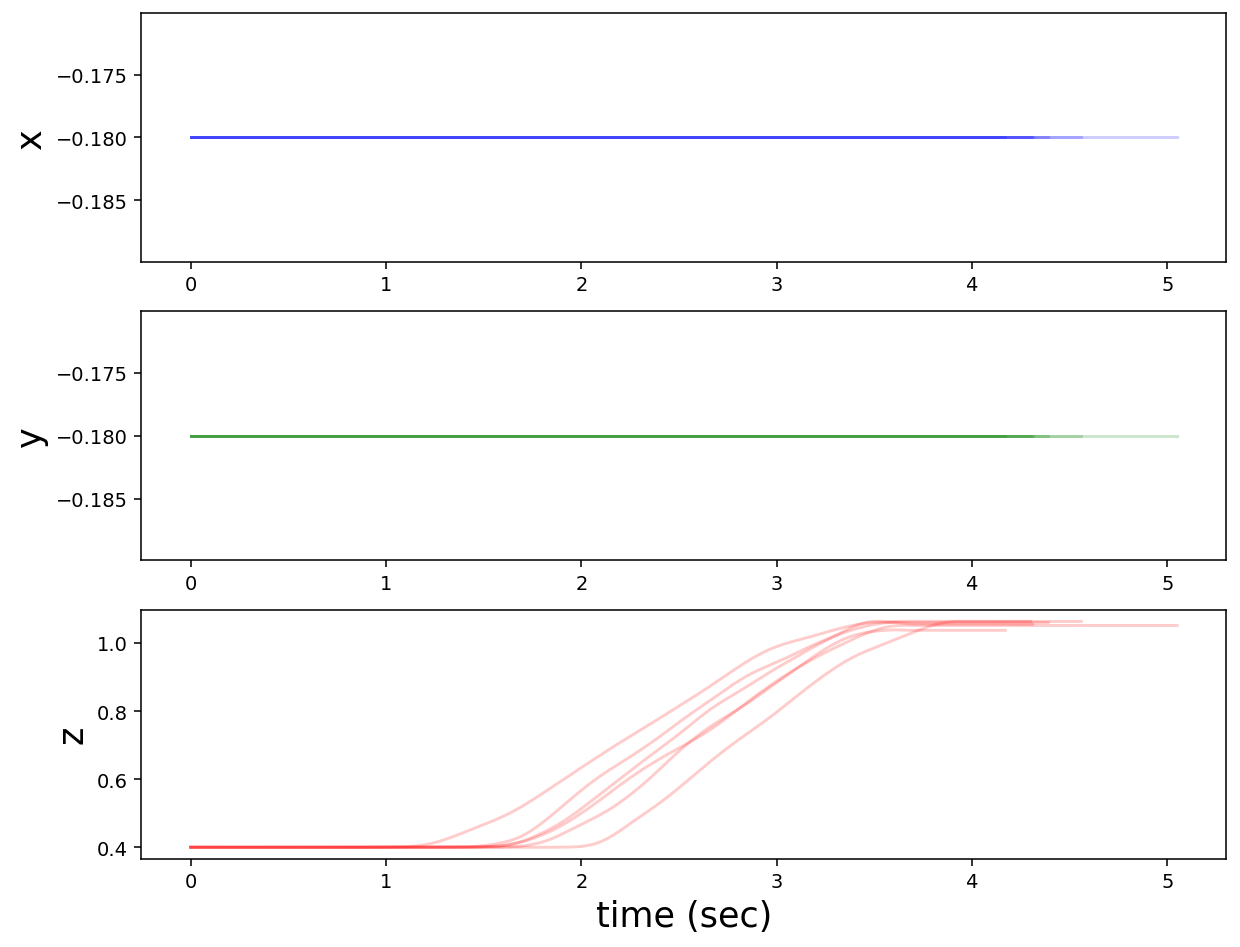

In [8]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['figure.dpi'] = 140
ax = plot_position(list_datasets,ls='-',alpha=0.2)
demon_data = deepcopy(list_datasets)
plt.show()

Preprocessing:
start & end cut

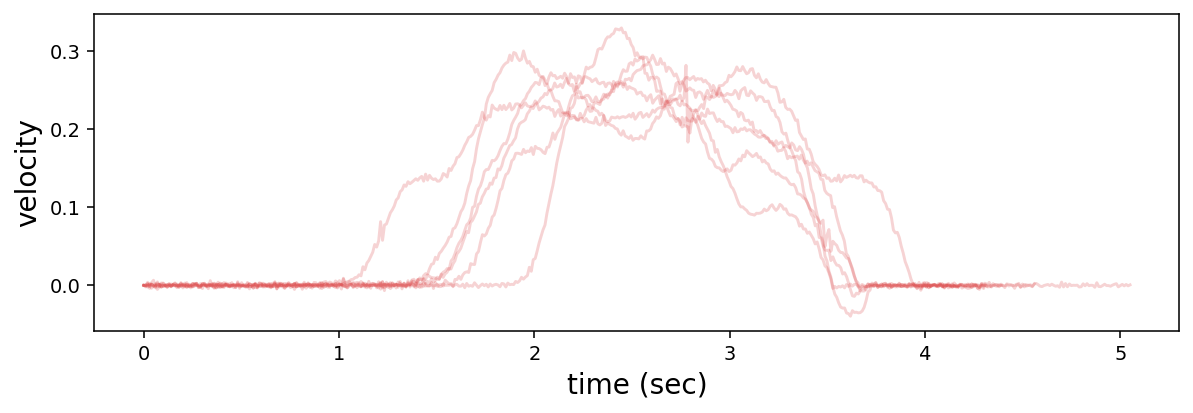

In [9]:
plt.rcParams["figure.figsize"] = (10,3)
plt.rcParams['figure.dpi'] = 140

list_datasets_ = []
for j in range(len(list_datasets)):
    list_datasets_.append([])

for i in range(len(list_datasets[0])):
    signal_i = np.array(list_datasets[2][i])
    dsignal_i = np.diff(signal_i,prepend = signal_i[0])
    
    t = np.linspace(0,dsignal_i.shape[0]*dt,dsignal_i.shape[0])
    plt.plot(t, dsignal_i/dt*0.6,alpha=0.2,c="tab:red")
    
    dsd_i = np.std(dsignal_i)
    dsignal_i[np.abs(dsignal_i) < (0+0.15*dsd_i) ] = 0
    
    # find start
    start = 0
    for t in range(len(dsignal_i)):
        if dsignal_i[t] != 0:
            start = t
            break
            
    # find end
    end = 0
    for t in range(len(dsignal_i)-1,-1,-1):
        if dsignal_i[t] != 0:
            end = t
            break
            
    for j in range(len(list_datasets)):
        signal_j = np.array(list_datasets[j][i])[start-1:end+1]
        list_datasets_[j].append(signal_j) 
plt.ylabel("velocity",fontsize="x-large")
plt.xlabel("time (sec)",fontsize="x-large")
plt.show()
list_datasets = deepcopy(list_datasets_)

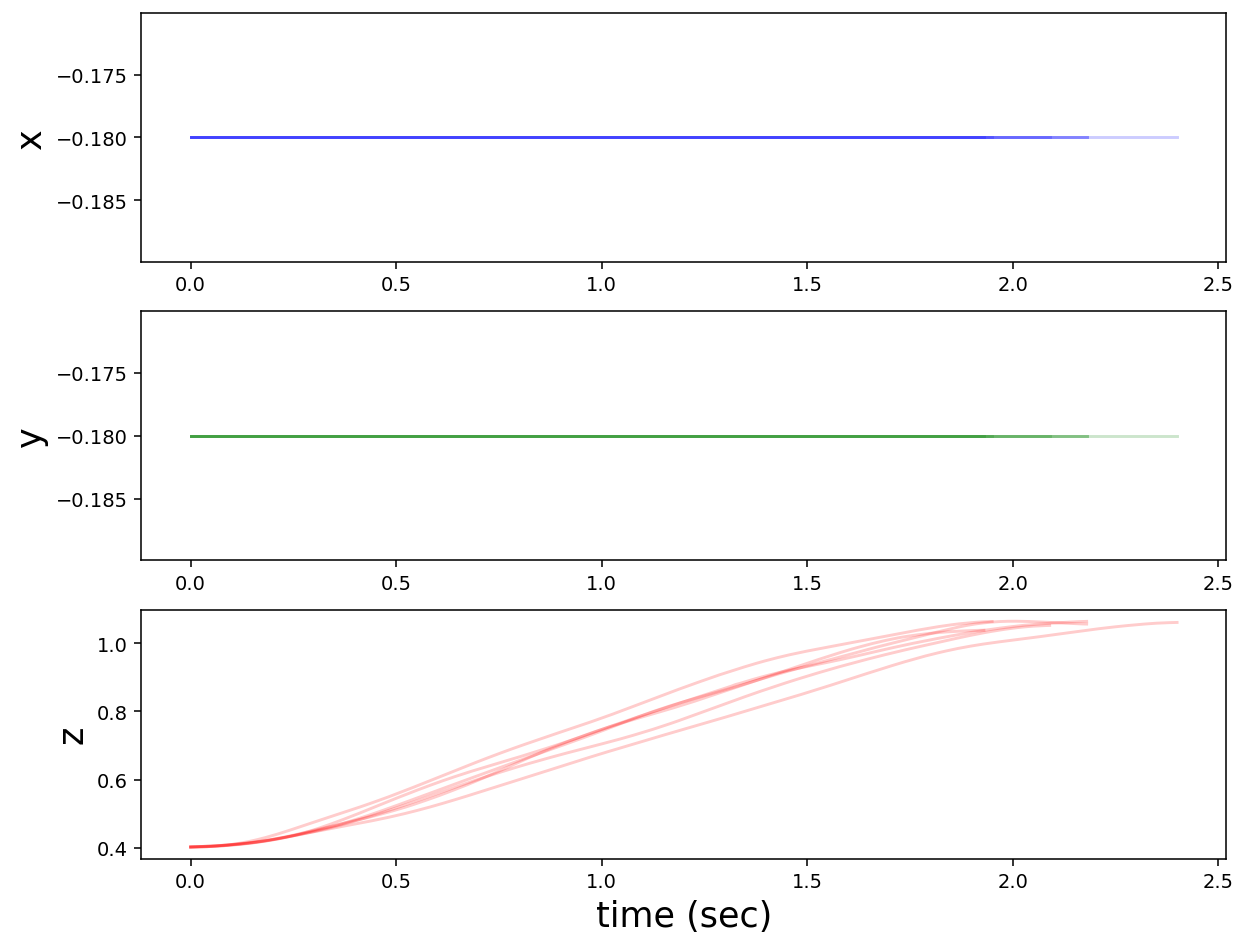

In [10]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['figure.dpi'] = 140
ax = plot_position(list_datasets,ls='-',alpha=0.2)
cut_data = deepcopy(list_datasets)
plt.show()

Preprocessing:
Start & End qualization

In [11]:
list_datasets_ = deepcopy(list_datasets)

# find the average start/end
avg_start = 0
avg_end = 0
for i in range(len(list_datasets[2])):
    signal_i = np.array(list_datasets[2][i])
    start = signal_i[0]
    end = signal_i[-1]
    avg_start += start
    avg_end += end
avg_start /= len(list_datasets[0])
avg_end /= len(list_datasets[0])
print(avg_start,avg_end)

# preprocess the signals
for i in range(len(list_datasets[2])):
    signal_i = np.array(list_datasets[2][i])
    psignal_i = deepcopy(signal_i)-deepcopy(signal_i[0])
    psignal_i = psignal_i*(avg_end-avg_start)/(signal_i[-1]-signal_i[0])
    psignal_i = psignal_i+avg_start
    list_datasets_[2][i] = psignal_i
    
list_datasets = deepcopy(list_datasets_)



0.4024002183385809 1.055282803252153


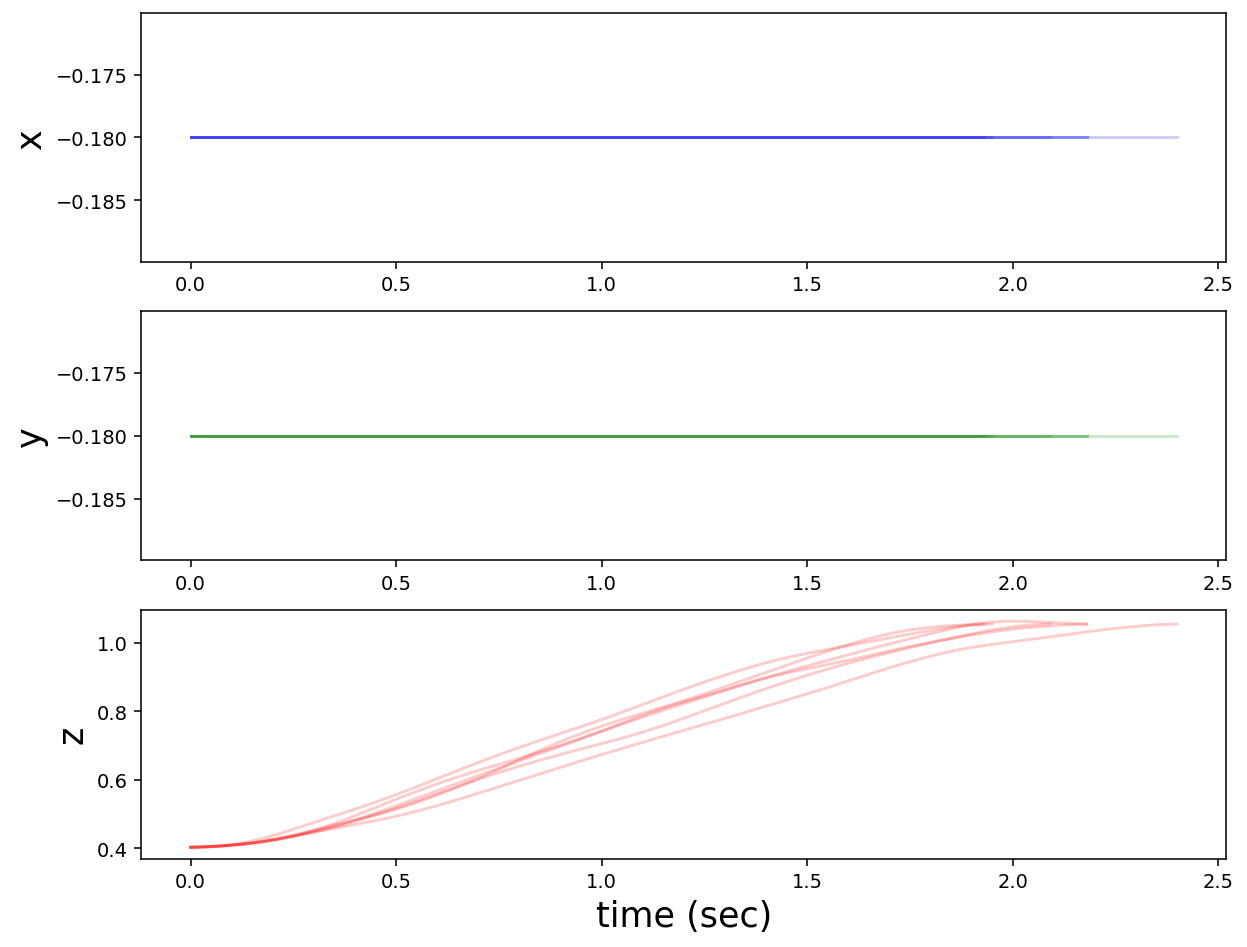

In [12]:
ax = plot_position(list_datasets,ls='-',alpha=0.2)
endequalized_data = deepcopy(list_datasets)
plt.show()

##### interpolate all to have the same length

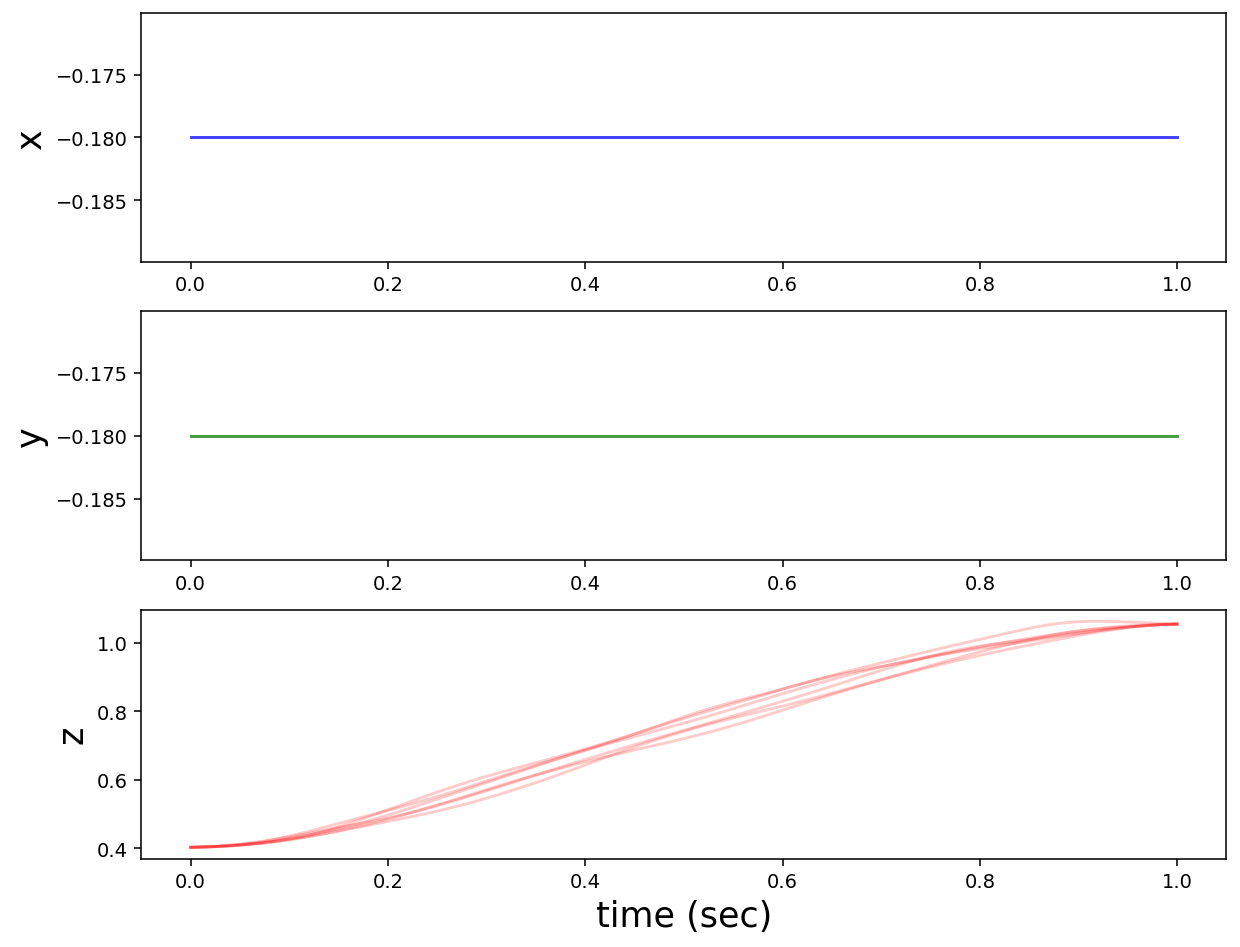

In [13]:
ax = None
list_preprocessed_datasets = dtwz.preprocess_dtw_input(deepcopy(list_datasets),
                                                       desired_length,
                                                       length_equalize=length_equalize,
                                                       start_equalize=start_equalize,
                                                       amplitude_equalize=amplitude_equalize)

ax = plot_position(list_preprocessed_datasets,ls='-',alpha=0.2)

plt.show()

---
## Step 3: Perform Dynamic Time Warping (or not?)
---
perform dynamic time warping on the preprocessed data

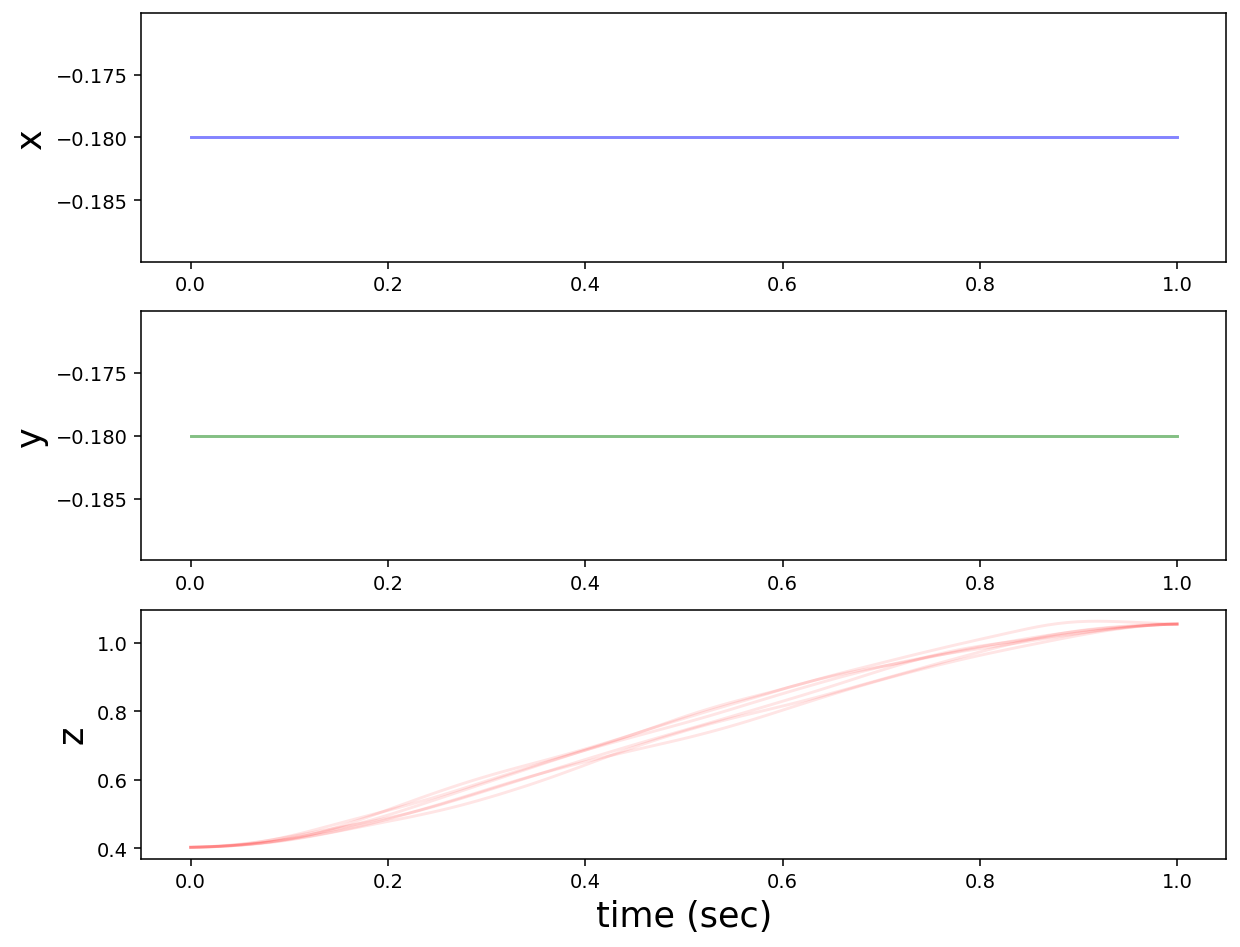

In [14]:
if perform_dtw:
    list_dtwed_datasets, r = dtwz.perform_dtw(deepcopy(np.array(list_preprocessed_datasets)),filter=(13,5))
else:
    list_dtwed_datasets = deepcopy(list_preprocessed_datasets)
    
ax = plot_position(list_dtwed_datasets,ls='-',alpha=0.1)
plt.show()

### Plot Z from all the preprocessing steps

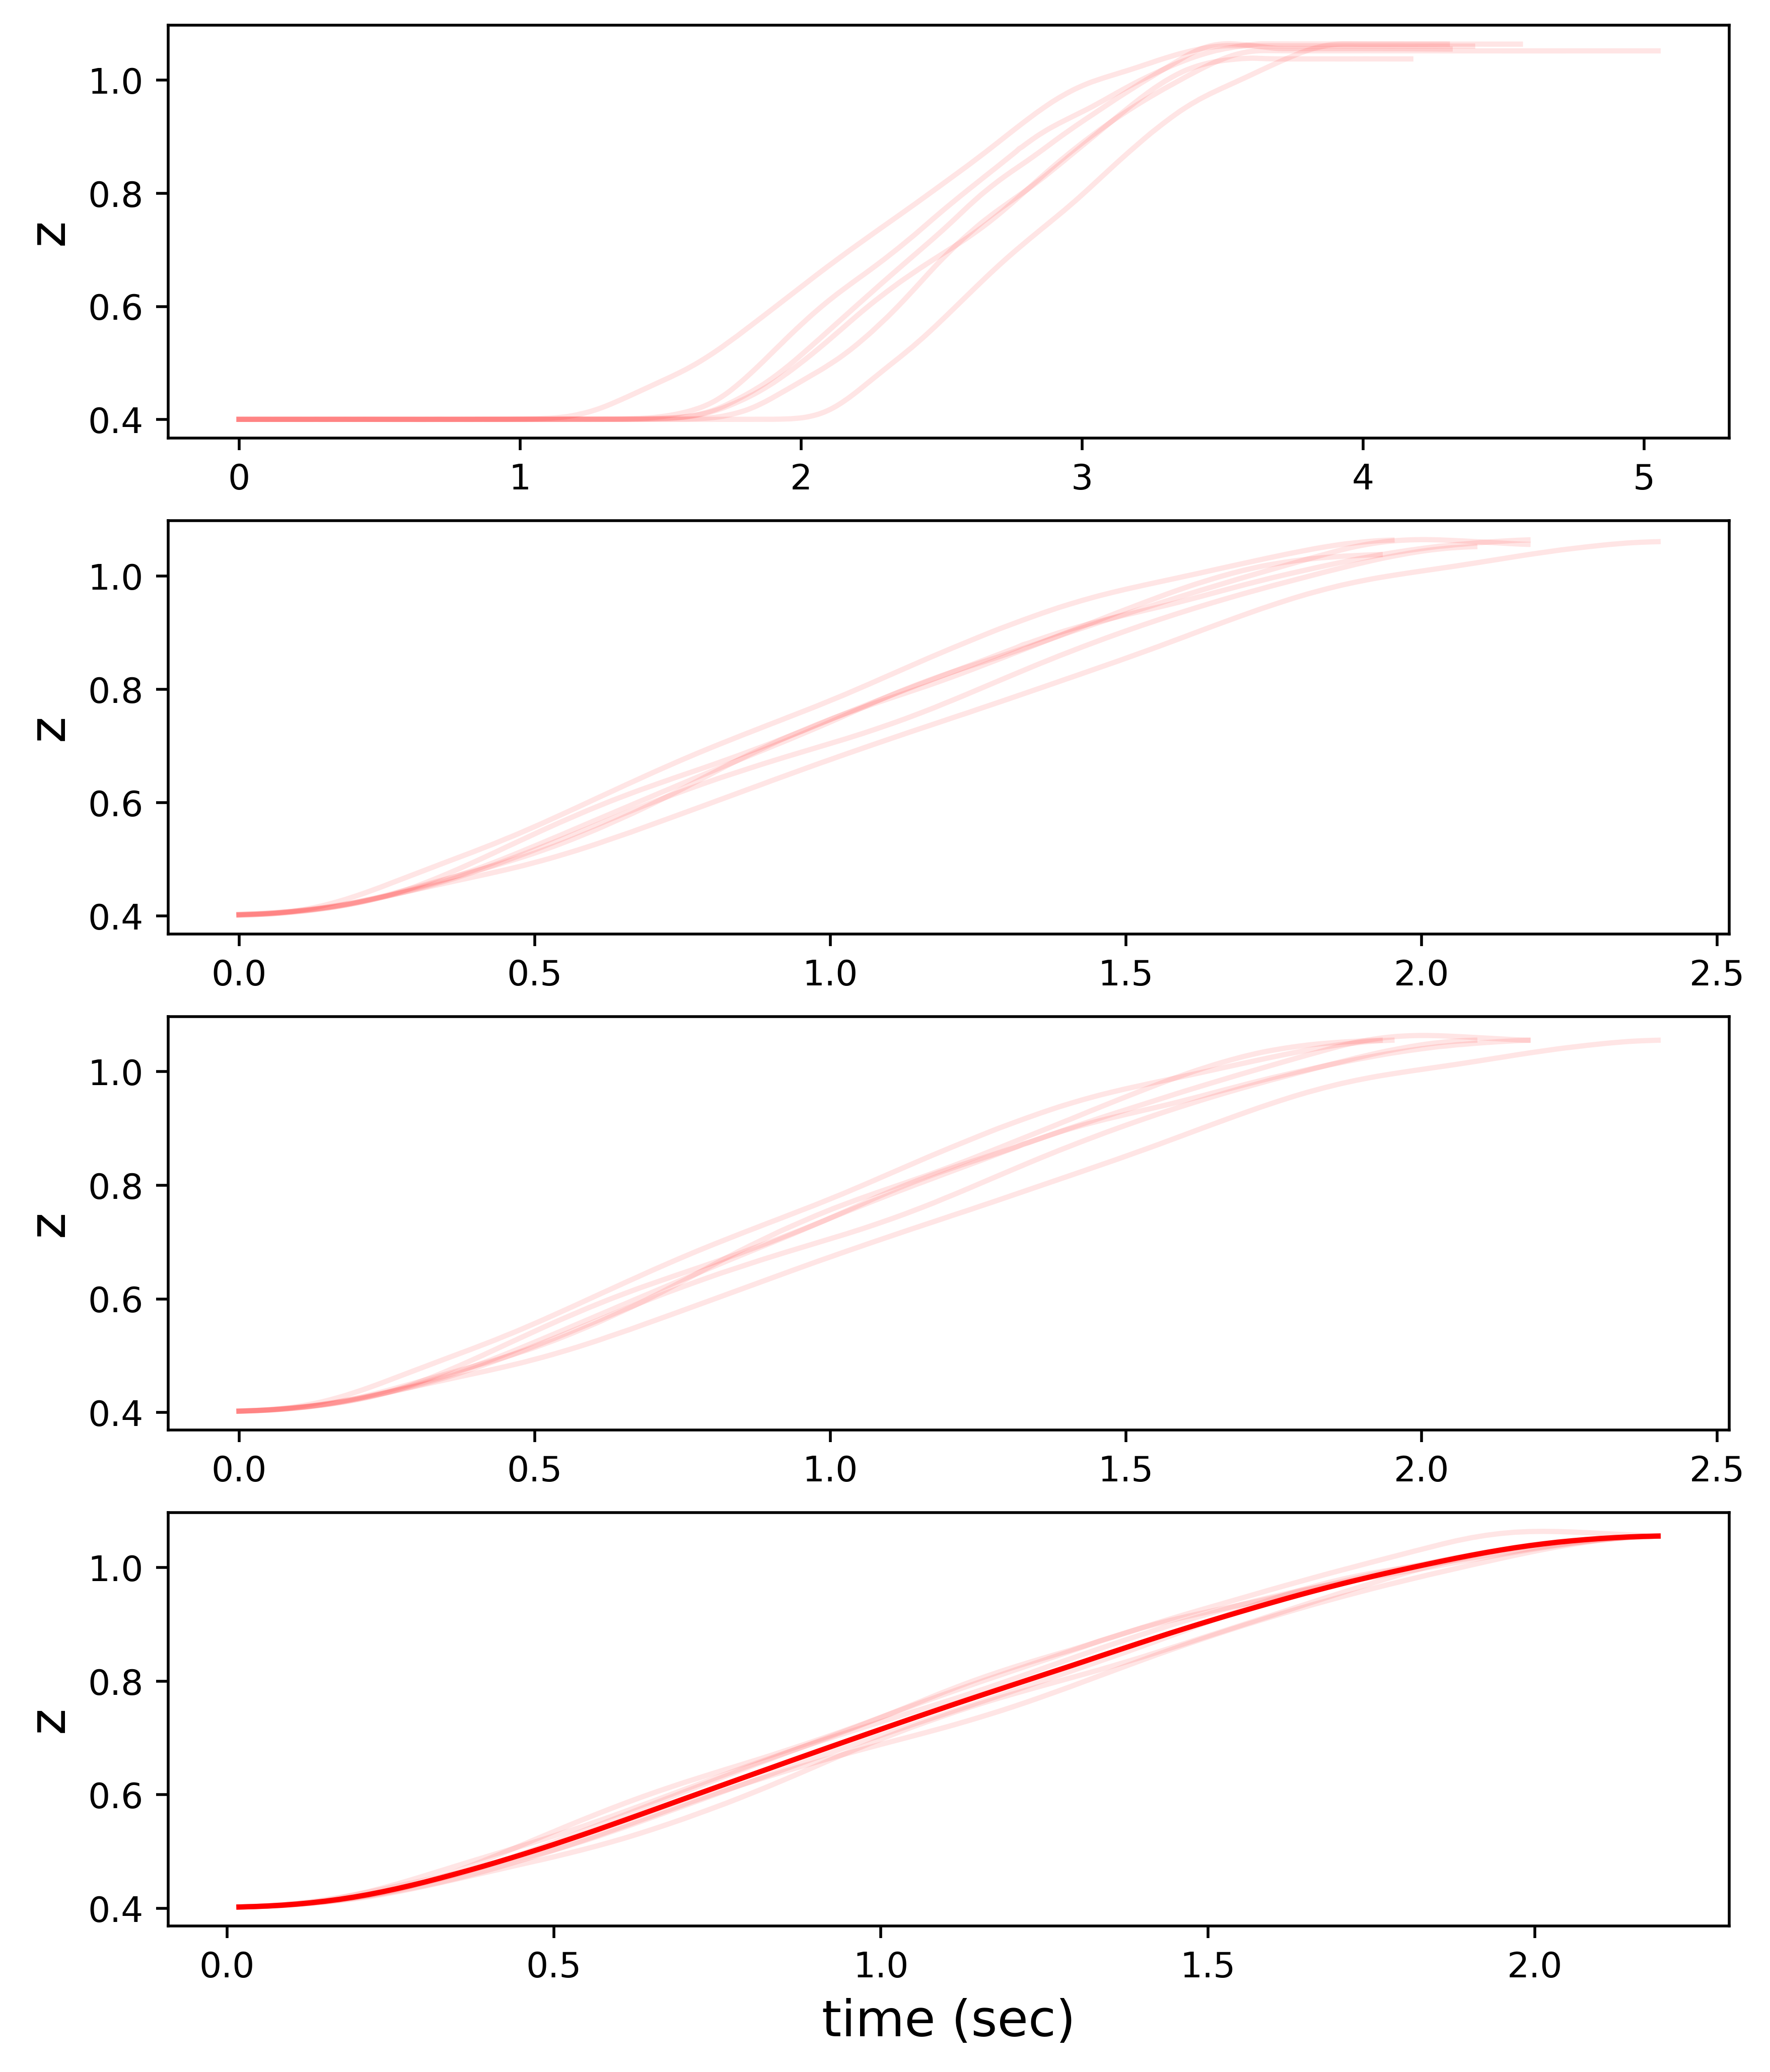

In [15]:
plt.rcParams["figure.figsize"] = (8,10)
plt.rcParams['figure.dpi'] = 500
fig, axs = plt.subplots(4,1)
alpha = 0.1
for i in range(len(demon_data[2])):
    t = np.linspace(0,len(demon_data[2][i])*dt,len(demon_data[2][i]))
    axs[0].plot(t,demon_data[2][i],c="red",alpha=alpha)
    
    t = np.linspace(0,len(cut_data[2][i])*dt,len(cut_data[2][i]))
    axs[1].plot(t,cut_data[2][i],c="red",alpha=alpha)
    
    t = np.linspace(0,len(endequalized_data[2][i])*dt,len(endequalized_data[2][i]))
    axs[2].plot(t,endequalized_data[2][i],c="red",alpha=alpha)
    
    t = list_dtwed_datasets[43,0,:]-1.5
    axs[3].plot(t,list_dtwed_datasets[2][i],c="red",alpha=alpha)
axs[3].plot(list_dtwed_datasets[43,0,:]-1.5,np.average(list_dtwed_datasets[2],0),c='red',alpha=1)
    
for i in range(4):
    axs[i].set_ylabel("z",fontsize='x-large')
axs[-1].set_xlabel("time (sec)",fontsize='x-large')
plt.show()

---
## Step 4: Parameter Estimation ( take time :) )
---
prepare the data

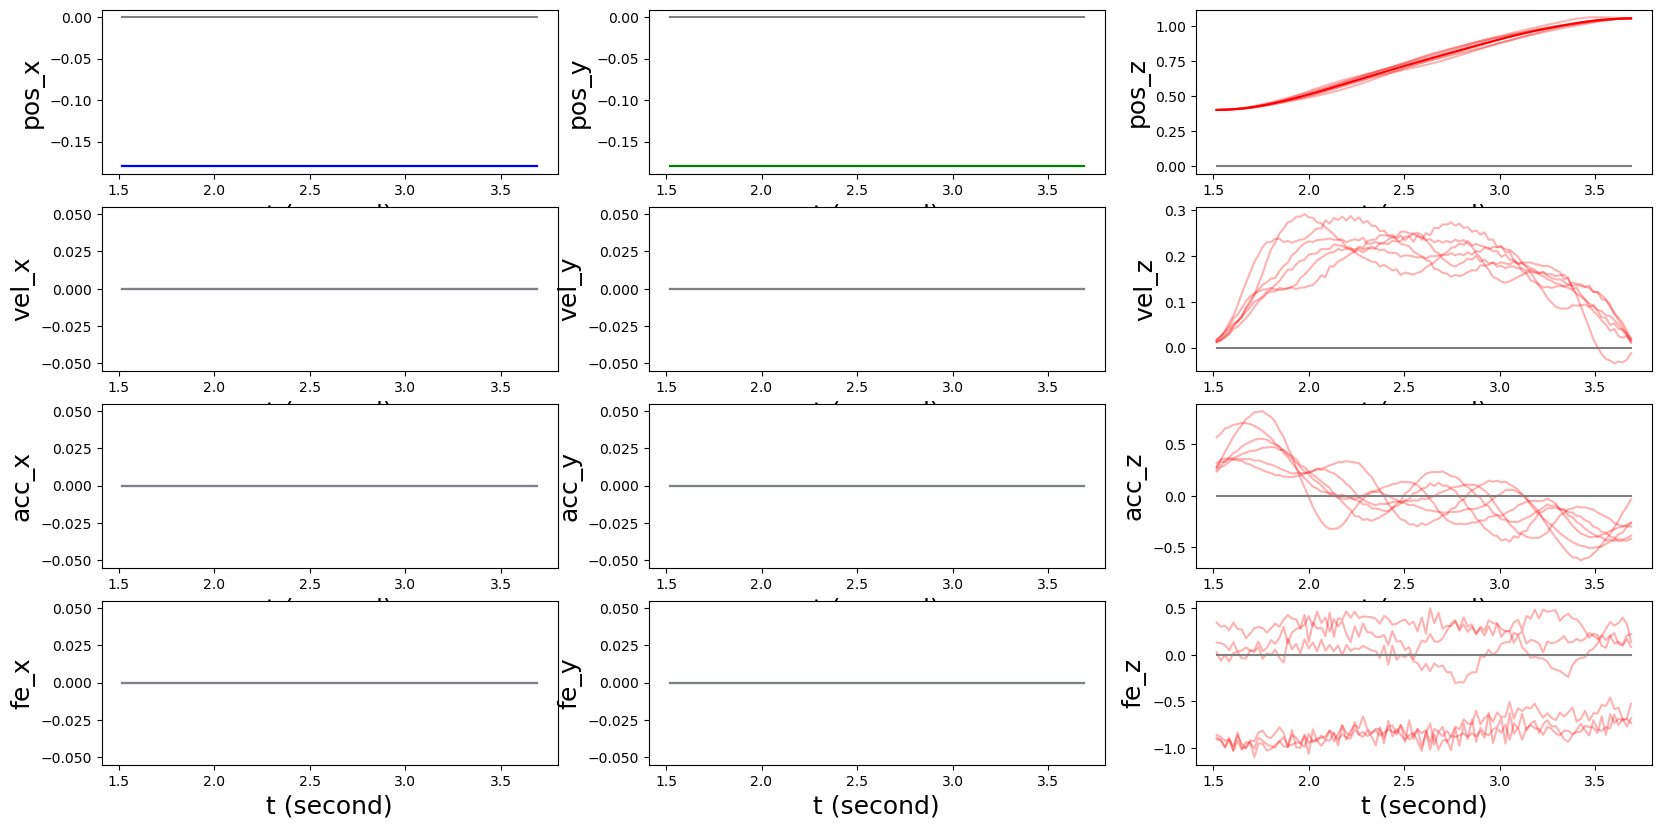

In [16]:
# data preparation
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['figure.dpi'] = 100
xs_hat = np.average(list_dtwed_datasets,1)[0:3,:] # average trajectory
xs = list_dtwed_datasets[0:3,:,:] # position
dxs = list_dtwed_datasets[7:10,:,:] # velocity
ddxs = list_dtwed_datasets[44:47,:,:] # acceleration
ts = list_dtwed_datasets[43,0,:] # time
fe = list_dtwed_datasets[13:16,:,:] # force 
ax = signals_plot([xs,dxs,ddxs,fe],xs_hat,alpha=0.3)
plt.show()

In [17]:
Kps = []
Kvs = []
Ims = []
Jas = []
for i in range(0,xs.shape[1]):
    
    print(i)
    Kpi, Kvi, Imi,losses = pez.estimate_parameter(ts,xs_hat,xs[:,i:i+1],dxs[:,i:i+1],ddxs[:,i:i+1],fe[:,i:i+1],
                                           window_size=l,loss_threshold=lstop,learning_rate=eta,
                                               estimatedKp=None,estimatedKv=None,estimatedIm=None,correction=True,verbose=False)
    
    Kps.append(Kpi)
    Kvs.append(Kvi)
    Ims.append(Imi)

0


loss: 0.034011002629995346: 100%|██████████| 90/90 [01:29<00:00,  1.01it/s] 


1


loss: 0.004922989755868912: 100%|██████████| 90/90 [01:57<00:00,  1.31s/it] 


2


loss: 0.21415598690509796:   7%|▋         | 6/90 [00:01<00:12,  6.67it/s]/media/zubuntu/Data/SDU/courses/F22_ProjectInAdvancedRobotics/encode-task-impedance-from-demonstration/src/offline_controller/../parameter_estimation/parameztimation.py:55: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2894.)
  S, V = torch.eig(B,eigenvectors=True)
loss: 0.014513728208839893: 100%|██████████| 90/90 [00:14<00:00,  6.22it/s]  


3


loss: 0.0016803735634312034: 100%|██████████| 90/90 [04:31<00:00,  3.02s/it] 


4


loss: 0.011650810949504375: 100%|██████████| 90/90 [04:01<00:00,  2.68s/it] 


5


loss: 0.002823783317580819: 100%|██████████| 90/90 [00:41<00:00,  2.19it/s]  


In [18]:
fe.shape

(3, 6, 100)

print(Kps[0].shape)
for i in range(len(Kps)):
    for j in range(len(Kps[i])):
        Kps[i][j,:,:] = np.array([[1,0,0],[0,1,0],[0,0,1]])*100
        Kvs[i][j,:,:] = np.array([[1,0,0],[0,1,0],[0,0,1]])*80
        Ims[i][j,:,:] = np.array([[1,0,0],[0,1,0],[0,0,1]])*100

Reconstruct the trajectory

0.011202217388035937
0.006453796577137789
0.031823823132999515
0.0034180004081715925
0.042315039691656675
0.019790895612470046


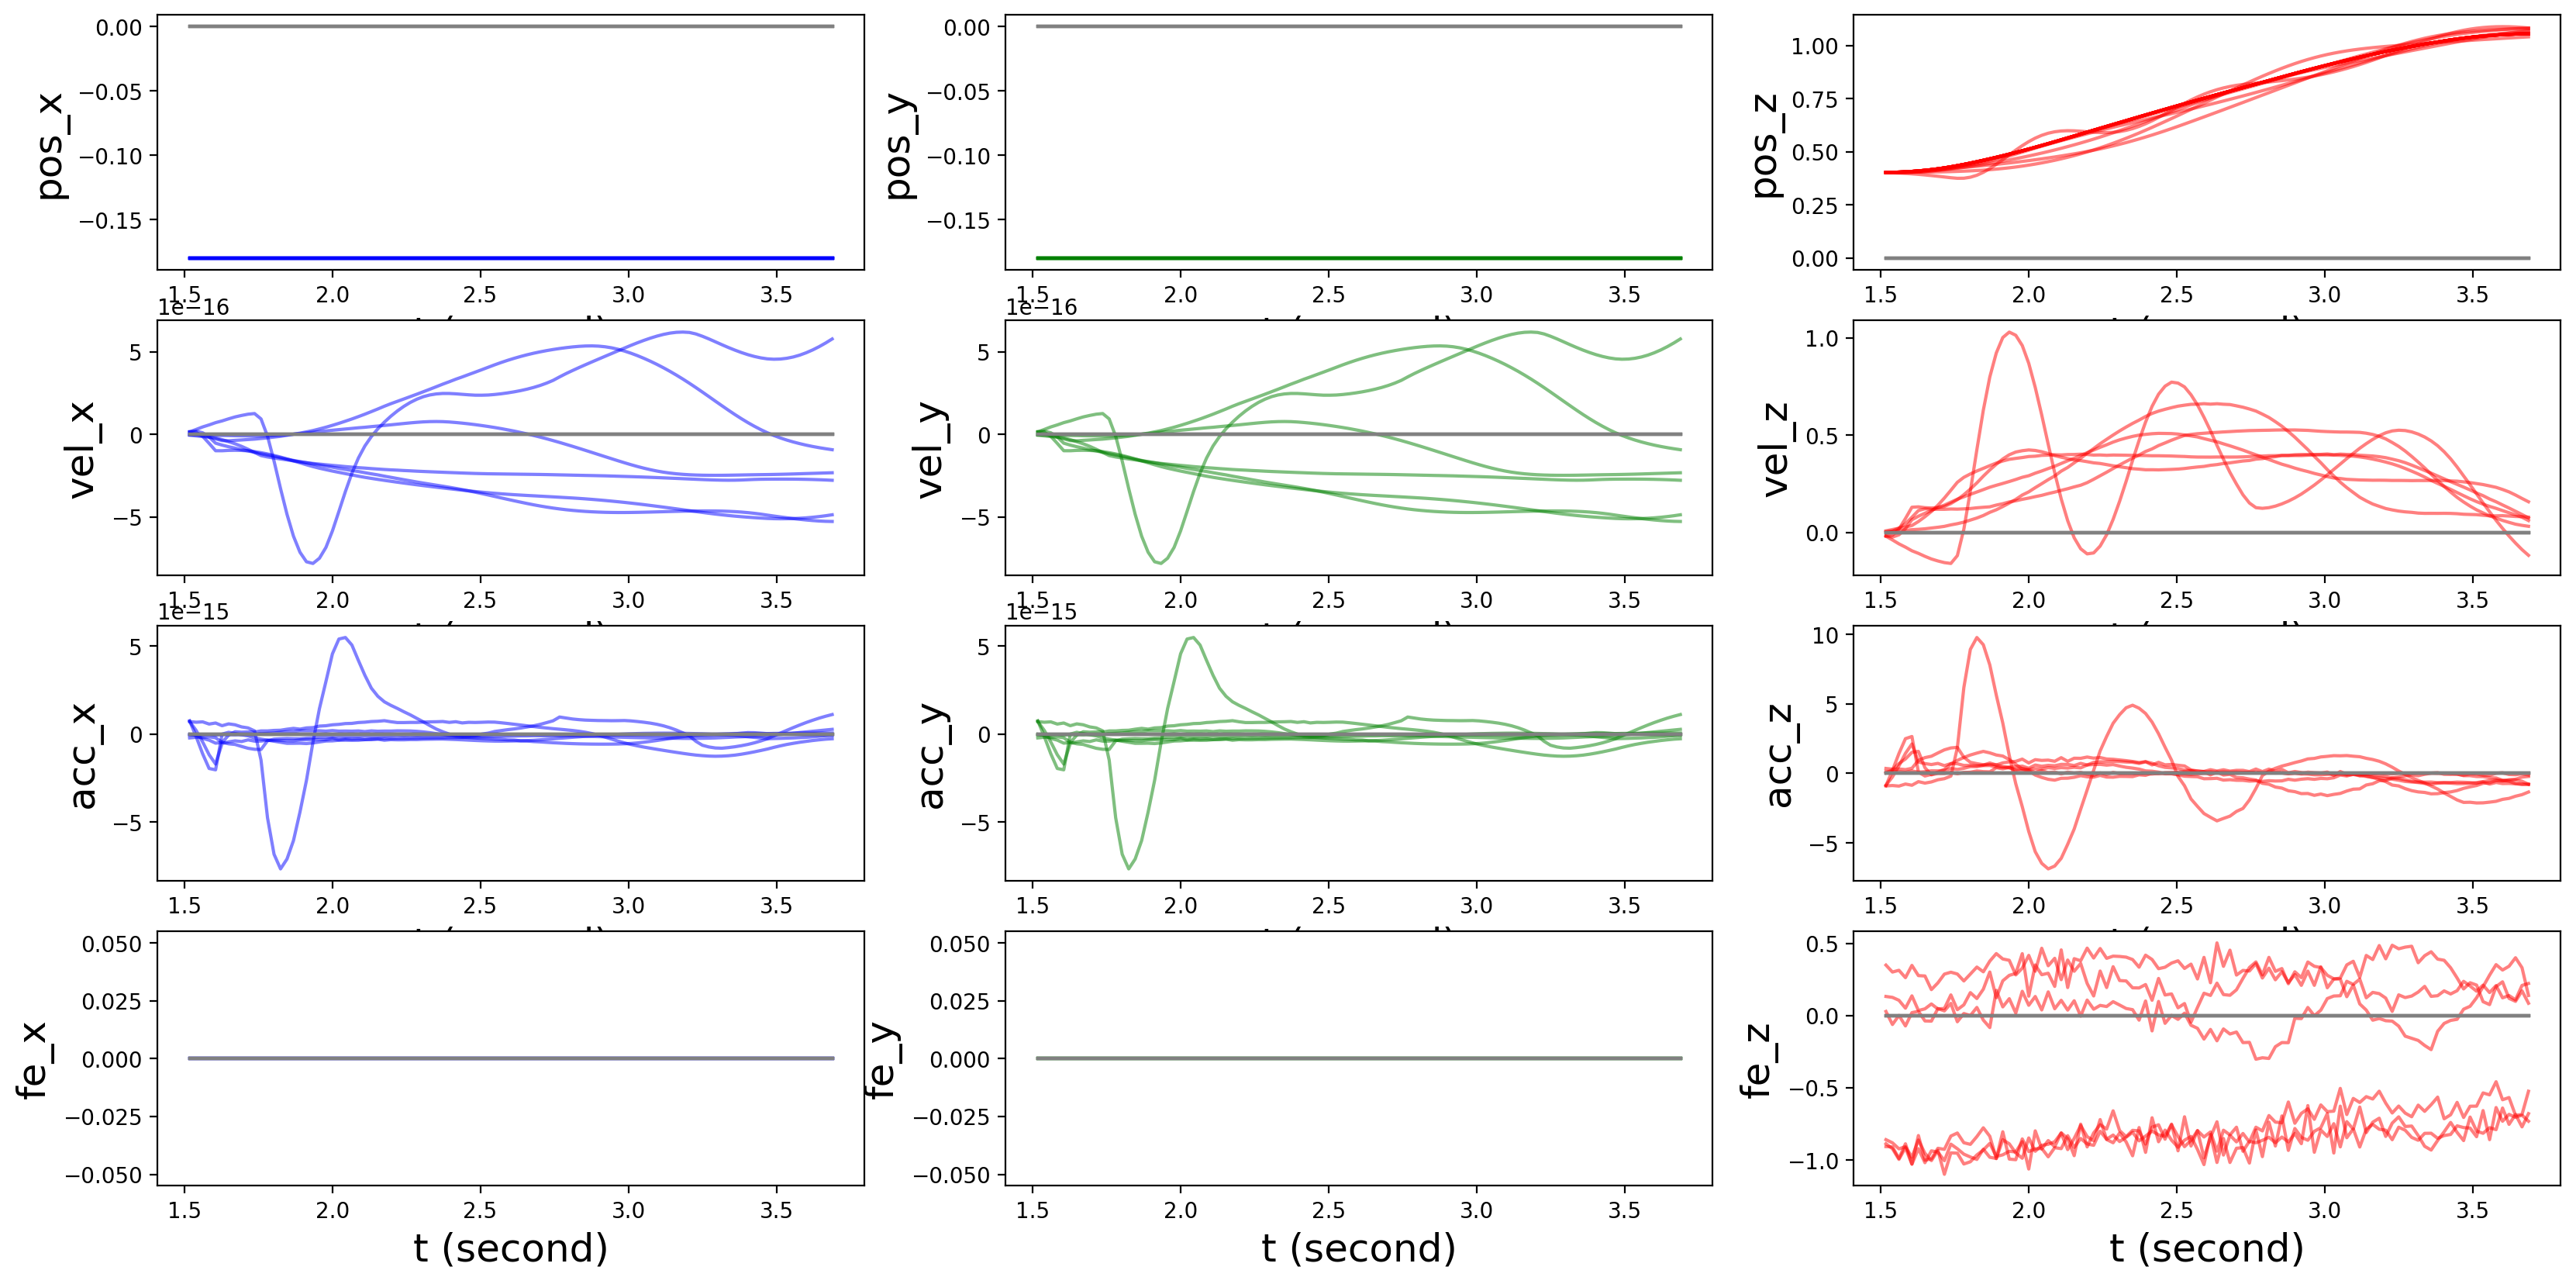

In [19]:
ax = None
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['figure.dpi'] = 200
for i in range(0,xs.shape[1]):
    xsr, dxsr, ddxsr = pez.reconstruct_trajectories(ts,xs_hat,xs_hat[:,0:1],fe[:,i:i+1],Kps[i]*10,Kvs[i],Ims[i],window_size = l) 
    ax = signals_plot([xsr, dxsr, ddxsr,fe[:,i:i+1,:]],xs_hat,axs=ax,alpha=0.5)
    e = np.sqrt(np.average(np.power(xsr - xs[:,i:i+1],2)))
    print(e)
plt.show()

## Step 5: Store The Parameters
the estimated parameters includes impedance parameters (upper diagonal parts of Kp, Kv, and Im), desired/average trajetory, and the force profile.

In [20]:
data = []
for param in [Kps,Kvs,Ims]:
    param_post = np.array(param)
    param_post = param_post[:,:param_post.shape[1]-int(l),:,:]
    param_post = np.concatenate([param_post[:,:,0,:],param_post[:,:,1,1:],param_post[:,:,2,2:]],axis=2) # extract the upper diagonal part
    data.append(np.expand_dims(param_post,0))
data = np.concatenate(data,axis=0)
firstdata = data[:,:,:1,:]
lastdata = data[:,:,-1:,:]
addeddata = []
for i in range(int(l//2)):
    addeddata.append(deepcopy(firstdata))
addeddata.append(data)
for i in range( int((desired_length-data.shape[2])//2)+1 ):
    addeddata.append(deepcopy(lastdata))
data = np.concatenate(addeddata,2)
tmax = np.average(list_dtwed_datasets[43,:,-1])
time_data = np.linspace(0,tmax,desired_length)
time_data = np.expand_dims(time_data,0)
new_xs_hat = deepcopy(xs_hat) + np.array([[-0.18],[-0.18],[0]])
#desired_traj = np.concatenate([time_data,new_xs_hat],0)

data = np.swapaxes(data,0,1)
data = np.swapaxes(data,2,3)[:,:,:,:-1]
Kp_data = data[:,0,:,:]*10
Kv_data = data[:,0,:,:]
Im_data = data[:,0,:,:]
time_data = np.expand_dims(time_data,0)
time_data = np.repeat(time_data,Kp_data.shape[0], axis=0)
desired_traj = np.expand_dims(new_xs_hat,0)
desired_traj = np.repeat(desired_traj,Kp_data.shape[0], axis=0)
force_data = np.swapaxes(fe,0,1)
# data = (#demonstration, #dof, data: { t(1), Kp(6), Kv(6), Im(6), x(1), y(1), z(1), fx(1), fy(1), fz(1)} , #timestep)
print(time_data.shape,Kp_data.shape,Kv_data.shape,Im_data.shape,desired_traj.shape,force_data.shape)
combined_data = np.concatenate([time_data,Kp_data,Kv_data,Im_data,desired_traj,force_data],axis=1)
print(combined_data.shape)

# uncomment these line to save the data
if 0:
    np.save(savepath+"estimatedparams2.npy", combined_data)

(6, 1, 100) (6, 6, 100) (6, 6, 100) (6, 6, 100) (6, 3, 100) (6, 3, 100)
(6, 25, 100)


In [21]:
print(np.array(time_data).shape)

(6, 1, 100)


#### Plot the learned parameter

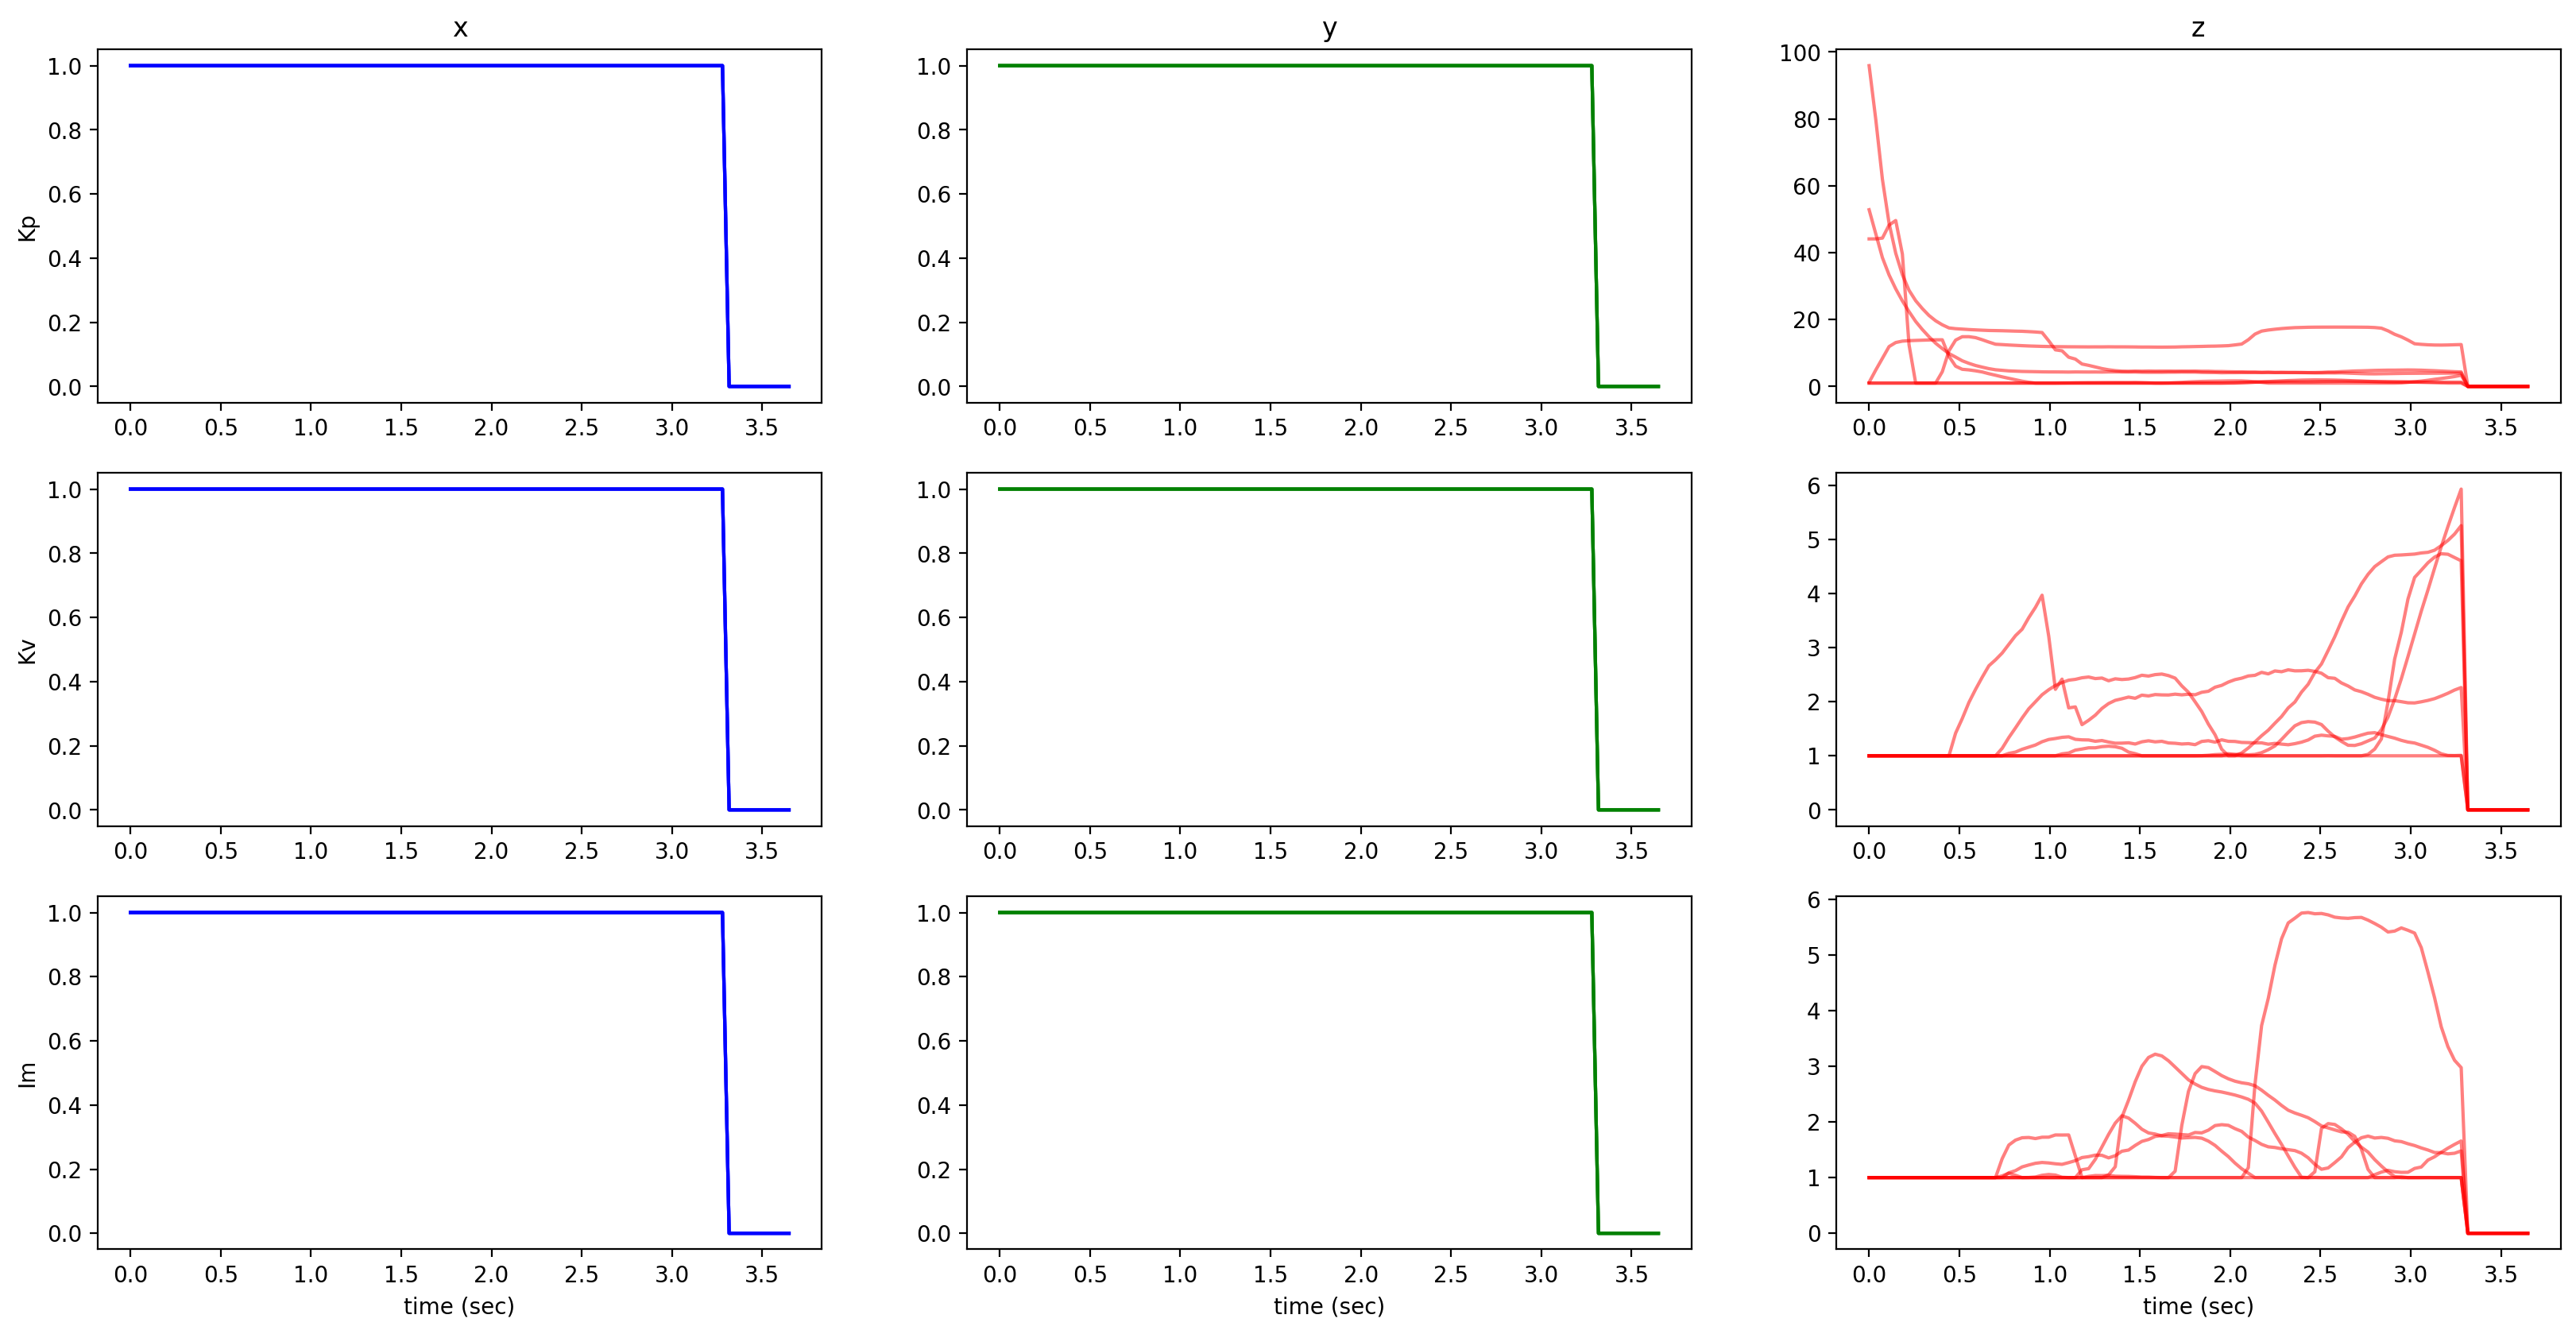

In [22]:
fig, axs = plt.subplots(3,3)
plt.rcParams["figure.figsize"] = (20,10)
for i in range(np.array(Kps).shape[0]):
    j = 0
    for Kj in [Kps,Kvs,Ims]:
        K = np.array(Kj)
        axs[j,0].plot(time_data[0,0,:],K[i,:,0,0],colors[0],alpha=0.5)
        axs[j,1].plot(time_data[0,0,:],K[i,:,1,1],colors[1],alpha=0.5)
        axs[j,2].plot(time_data[0,0,:],K[i,:,2,2],colors[2],alpha=0.5)
        j+= 1
axs[0][0].set_ylabel("Kp")
axs[1][0].set_ylabel("Kv")
axs[2][0].set_ylabel("Im")
axs[0][0].set_title("x")
axs[0][1].set_title("y")
axs[0][2].set_title("z")
for i in range(3):
    axs[-1][i].set_xlabel("time (sec)")
plt.show()

#### Plot the trajectory along with the estimated parameters

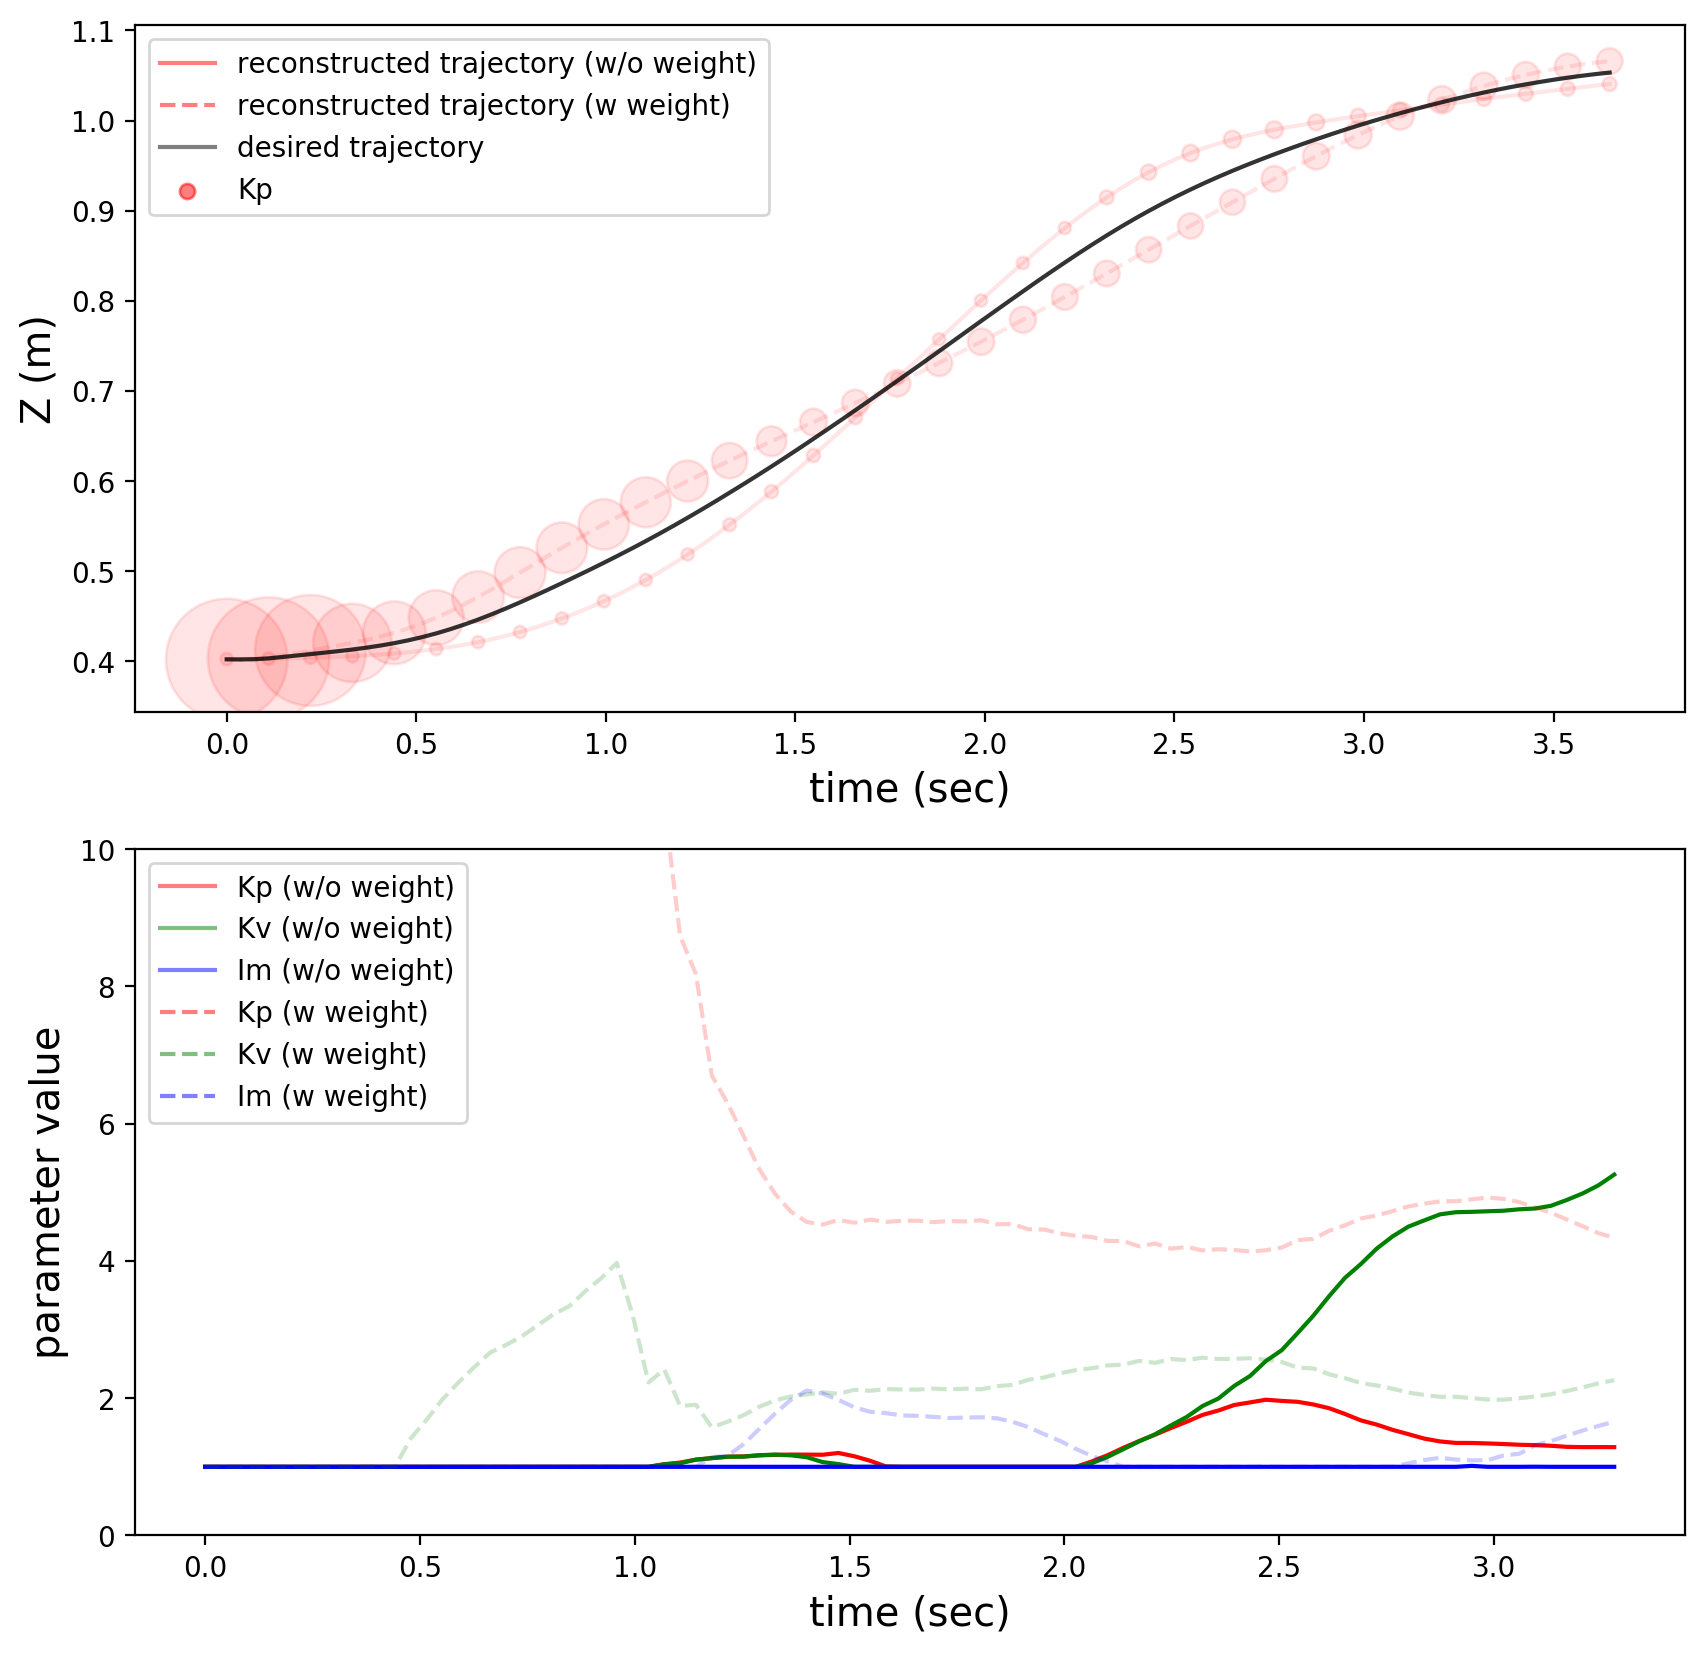

In [25]:
fig, axs = plt.subplots(2,1)
plt.rcParams['figure.dpi'] = 200
plt.rcParams["figure.figsize"] = (10,10)

xsr_avg = []
for i in range(2,xs.shape[1]-2):
    xsr, dxsr, ddxsr = pez.reconstruct_trajectories(ts,xs_hat,xs_hat[:,0:1],fe[:,i:i+1],Kps[i]*10,Kvs[i],Ims[i],window_size = l) 
    
    fz = fe[:,i:i+1][2,0,0]
    lstyle = '-' if fz > -0.5 else '--'
    axs[0].plot(time_data[0,0,:],xsr[2][0],c="red",alpha=0.1,ls=lstyle)
    axs[0].scatter(time_data[0,0,:][::3],xsr[2][0][::3],(np.abs(Kp_data[i,5,::3])*2),c="red",alpha=0.1)
    
    alpha = 0.2 if lstyle == '--' else 1
    axs[1].plot(time_data[0,0,:-l],Kps[i][:-l,2,2],c='red',ls=lstyle,alpha=alpha)
    axs[1].plot(time_data[0,0,:-l],Kvs[i][:-l,2,2],c='green',ls=lstyle,alpha=alpha)
    axs[1].plot(time_data[0,0,:-l],Ims[i][:-l,2,2],c='blue',ls=lstyle,alpha=alpha)
    
    xsr_avg.append(xsr[2][0])
xsr_avg = np.average(np.array(xsr_avg),0)
axs[0].plot(time_data[0,0,:],xsr_avg,c="black",alpha=0.8,ls='-')
axs[1].set_ylim([0,10])

axs[0].set_ylabel("Z (m)",fontsize='x-large')
axs[1].set_ylabel("parameter value",fontsize='x-large')

for i in range(2):
    axs[i].set_xlabel("time (sec)",fontsize='x-large')

# legend
leg = axs[0].legend(['reconstructed trajectory (w/o weight)','reconstructed trajectory (w weight)',
                     'desired trajectory','Kp'],ncol=1,loc='upper left')
for lh in leg.legendHandles: 
    lh.set_alpha(0.5)
leg = axs[1].legend(['Kp (w/o weight)','Kv (w/o weight)',"Im (w/o weight)",
                    'Kp (w weight)','Kv (w weight)',"Im (w weight)"],ncol=1,loc='upper left')
for lh in leg.legendHandles: 
    lh.set_alpha(0.5)
    
plt.show()